# Biomedical Data Science HW1

1. L-CORE (patient's internal temperature in C): 
high (> 37), mid (>= 36 and <= 37), low (< 36) 
2. L-SURF (patient's surface temperature in C): 
high (> 36.5), mid (>= 36.5 and <= 35), low (< 35) 
3. L-O2 (oxygen saturation in %): 
excellent (>= 98), good (>= 90 and < 98), 
fair (>= 80 and < 90), poor (< 80) 
4. L-BP (last measurement of blood pressure): 
high (> 130/90), mid (<= 130/90 and >= 90/70), low (< 90/70) 
5. SURF-STBL (stability of patient's surface temperature): 
stable, mod-stable, unstable 
6. CORE-STBL (stability of patient's core temperature) 
stable, mod-stable, unstable 
7. BP-STBL (stability of patient's blood pressure) 
stable, mod-stable, unstable 
8. COMFORT (patient's perceived comfort at discharge, measured as 
an integer between 0 and 20) 
9. decision ADM-DECS (discharge decision): 
I (patient sent to Intensive Care Unit), 
S (patient prepared to go home), 
A (patient sent to general hospital floor)

In [10]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)

# Problem 1: Load Dataset

In [11]:
# Load Dataset in Panda Dataframe
names = ['L-CORE', 'L-SURF','L-O2','L-BP','SURF-STBL','CORE-STBL','BP-STEBL','COMFORT','ADM-DECS']
Dataset = pd.read_csv('post-operative.data',header=None,names=names)

# Problem 2A: PairGrid for Violinplots

Do violineplots between all categorical features and comfort

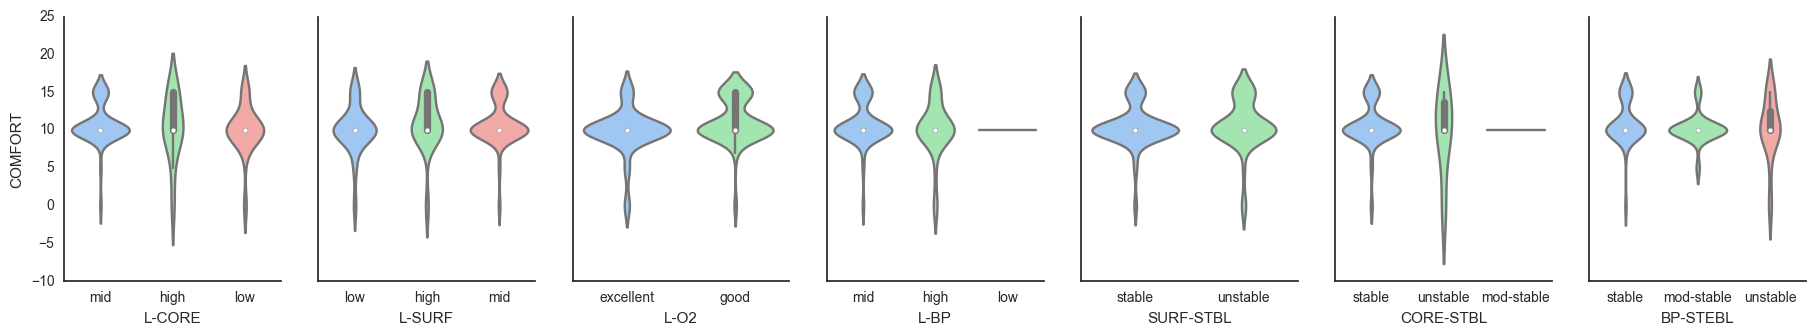

In [12]:
g = sns.PairGrid(Dataset,
                 x_vars=['L-CORE', 'L-SURF','L-O2','L-BP','SURF-STBL','CORE-STBL','BP-STEBL'],
                 y_vars=['COMFORT'],
                 aspect=.75, size=3.5)
g.map(sns.violinplot, palette="pastel");

# Problem 2B: Counterplot

Do three features of choice and do a counterplot

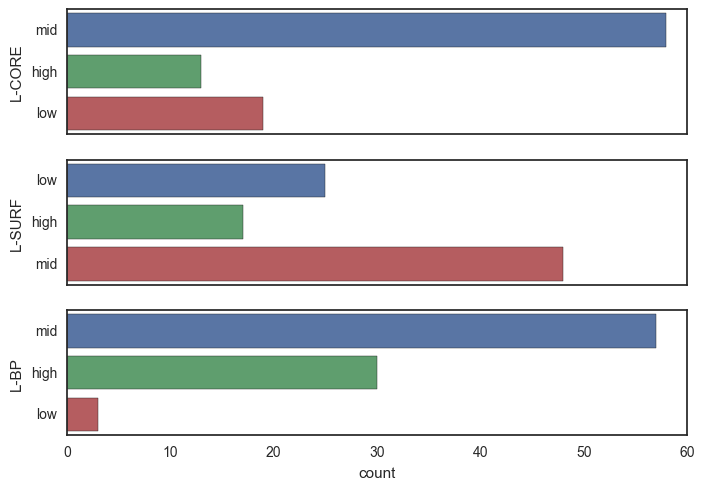

In [29]:
f, axarr = plt.subplots(3, sharex=True)
axarr[0] = sns.countplot(data=Dataset, y='L-CORE',ax=axarr[0])
axarr[0].set_xlabel('')
axarr[1] = sns.countplot(data=Dataset, y='L-SURF',ax=axarr[1])
axarr[1].set_xlabel('')
axarr[2] = sns.countplot(data=Dataset, y='L-BP',ax=axarr[2])